$\chi_{\perp}^{2h}$


$\xi = (r/r_0)^{\gamma}$


$\chi_{\perp} = \int \xi ds$

rate of incidence = $\lambda$



$f_c = 1 - \exp(-\lambda)$

$\lambda = (1 + [\Sigma \chi_i])~\langle dN/dz | C_0, \alpha \rangle \delta z$

$\langle dN/dz\rangle = C_0(1 + z)^{\alpha}$

$(...) = (R_{\perp}, M | r_0, \gamma, \beta)$

$\chi^{100}(...) \chi^{200}(...) \chi^{300}(...) \chi^{400}(...) \chi^{500}(...)$

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.table import Table, vstack
from cgmsquared import load_cgmsquared
import numpy as np
from astropy.cosmology import Planck15 as cosmo
import casbah.gal_properties as caprop
import haloclustering.data as datamodule
import cgmsquared.clustering2 as c2
import pickle
import os
from astropy.cosmology import Planck15 as cosmo
import pandas as pd
import glob
from cgmsquared import clustering as cgm2_cluster
import haloclustering.evalulate_model as evaluate


plt.rcParams['font.serif'] = "DejaVu Serif"
plt.rcParams['font.family'] = "serif"

plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.size'] = 16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# get data
df = pd.read_csv('/Users/mwilde/python/haloclustering/haloclustering/data/combined_df.csv')
df['log_rho'] = np.log10(df.rho)
df.sort_values('rho', inplace=True)

df.dropna(subset=['mstars'], inplace=True)

In [4]:
# params
r0 = 1.5
gamma = 3
r0_2 = 3.8
gamma_2 = 1.7
beta = 2
beta2h  = 0.1
dndz_index = 1.5
dndz_coeff = 25

params = (r0, gamma, r0_2, gamma_2, beta, beta2h, dndz_index, dndz_coeff)
dv_chunk = 100
dvlist = np.arange(100, 501, dv_chunk)

from haloclustering.velocitymodels import velocityModel1h2h

In [5]:
model = velocityModel1h2h(df, dvlist=dvlist)
model.log_probability(params), model.log_prior(), model.phit_sum().shape, model.log_likelihood()

(-37711.808867553926, -6.07163818139239, (7392, 5), -37705.737229372535)

In [6]:
np.isnan(model.chi_perp(model.r0func_1h(), model.gamma)).any()


False

In [7]:
np.isnan(model.chi_perp(model.r0func_2h(), model.gamma_2)).any()

False

In [8]:
self = model
chi_perp1 = self.chi_perp(self.r0func_1h(), self.gamma)
chi_perp2 = self.chi_perp(self.r0func_2h(), self.gamma_2)
sum_of_chi = chi_perp1 + chi_perp2
self.mean_dNdz()[:, None]
rate_of_incidence = (1 + sum_of_chi) * self.mean_dNdz()[:, None]
rate_of_incidence
prob_miss = np.exp(-rate_of_incidence)
prob_hit = 1 - prob_miss
prob_hit = np.clip(prob_hit, 0.00001, 0.99)
prob_hit[:, 2]

array([0.03562989, 0.02545229, 0.99      , ..., 0.03444012, 0.03153922,
       0.03150801])

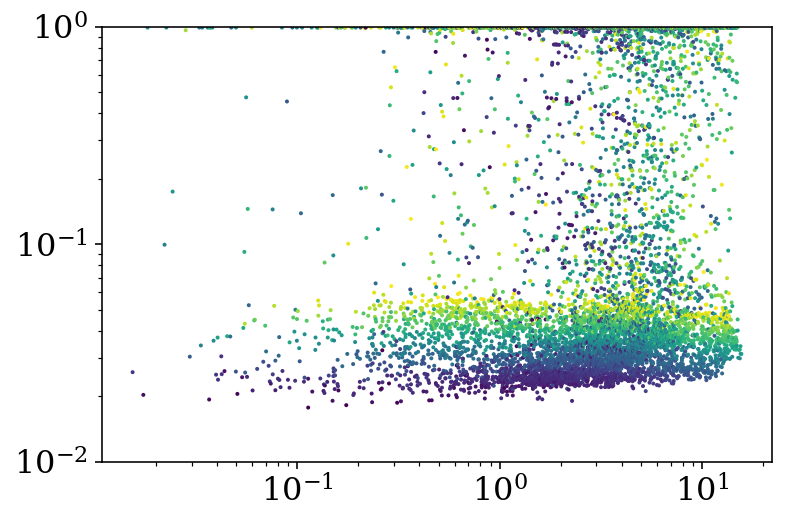

In [9]:
plt.scatter(model.rho_com, prob_hit[:,4], s=1, c=model.z);
plt.yscale('log');
plt.ylim(1e-2, 1)
plt.xscale('log')



In [10]:
model.rho_com.max(), model.mass/model.m0

(15.61214875548008,
 array([2.19382179e-01, 8.75718354e-03, 2.96119297e+01, ...,
        1.93178829e+00, 9.05527451e-01, 1.03081406e+00]))

In [11]:

initial = np.array(params)


from multiprocessing import Pool
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

with Pool() as pool:
    sampler = evaluate.posterior_sampler(initial, model.log_probability, nsteps=4000, solnisobject=False, pool=pool)

 65%|██████▍   | 2583/4000 [24:53<20:23,  1.16it/s]/Users/mwilde/python/haloclustering/haloclustering/velocitymodels.py:214: RuntimeWarning: overflow encountered in exp
  prob_miss = np.exp(-rate_of_incidence)
100%|██████████| 4000/4000 [36:53<00:00,  1.81it/s]


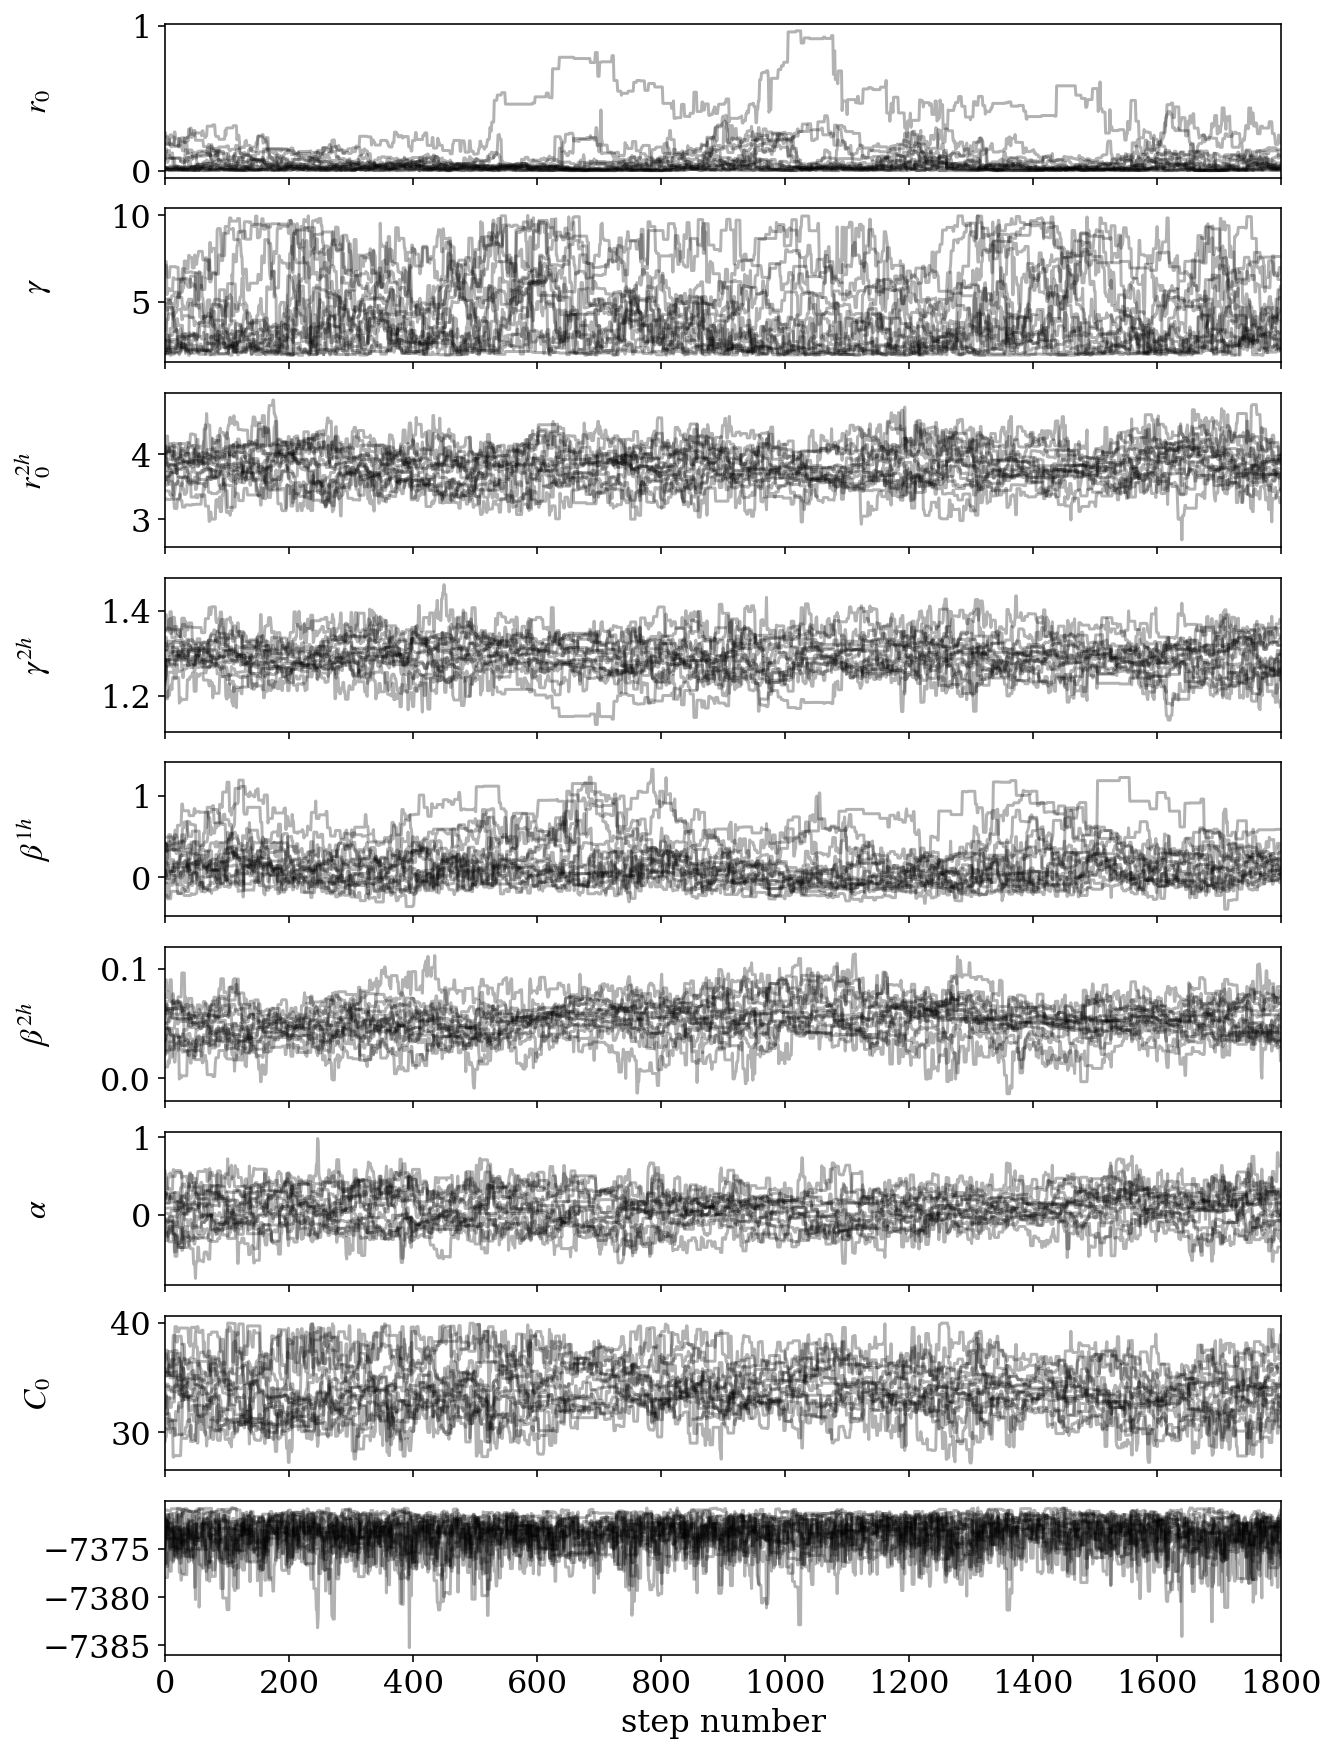

In [17]:
discard = 2200
samples = sampler.get_chain(discard=discard)
flat_samples = sampler.get_chain(discard=discard, thin=1, flat=True)

ndim = samples.shape[2]

# plot
# r0, gamma, r0_2, gamma_2, beta1, beta2, beta2h, dndz_index, dndz_coeff
fig, axes = plt.subplots(nrows=ndim+1, figsize=(10, 15), sharex=True)
labels = [r"$r_{0}$", r"$\gamma$", r"$r_0^{2h}$", r"$\gamma^{2h}$", r"$\beta^{1h}$", r"$\beta^{2h}$", r"$\alpha$", r'$C_0$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

axes[-1].plot(sampler.lnprobability.T[discard:], "k", alpha=0.3);

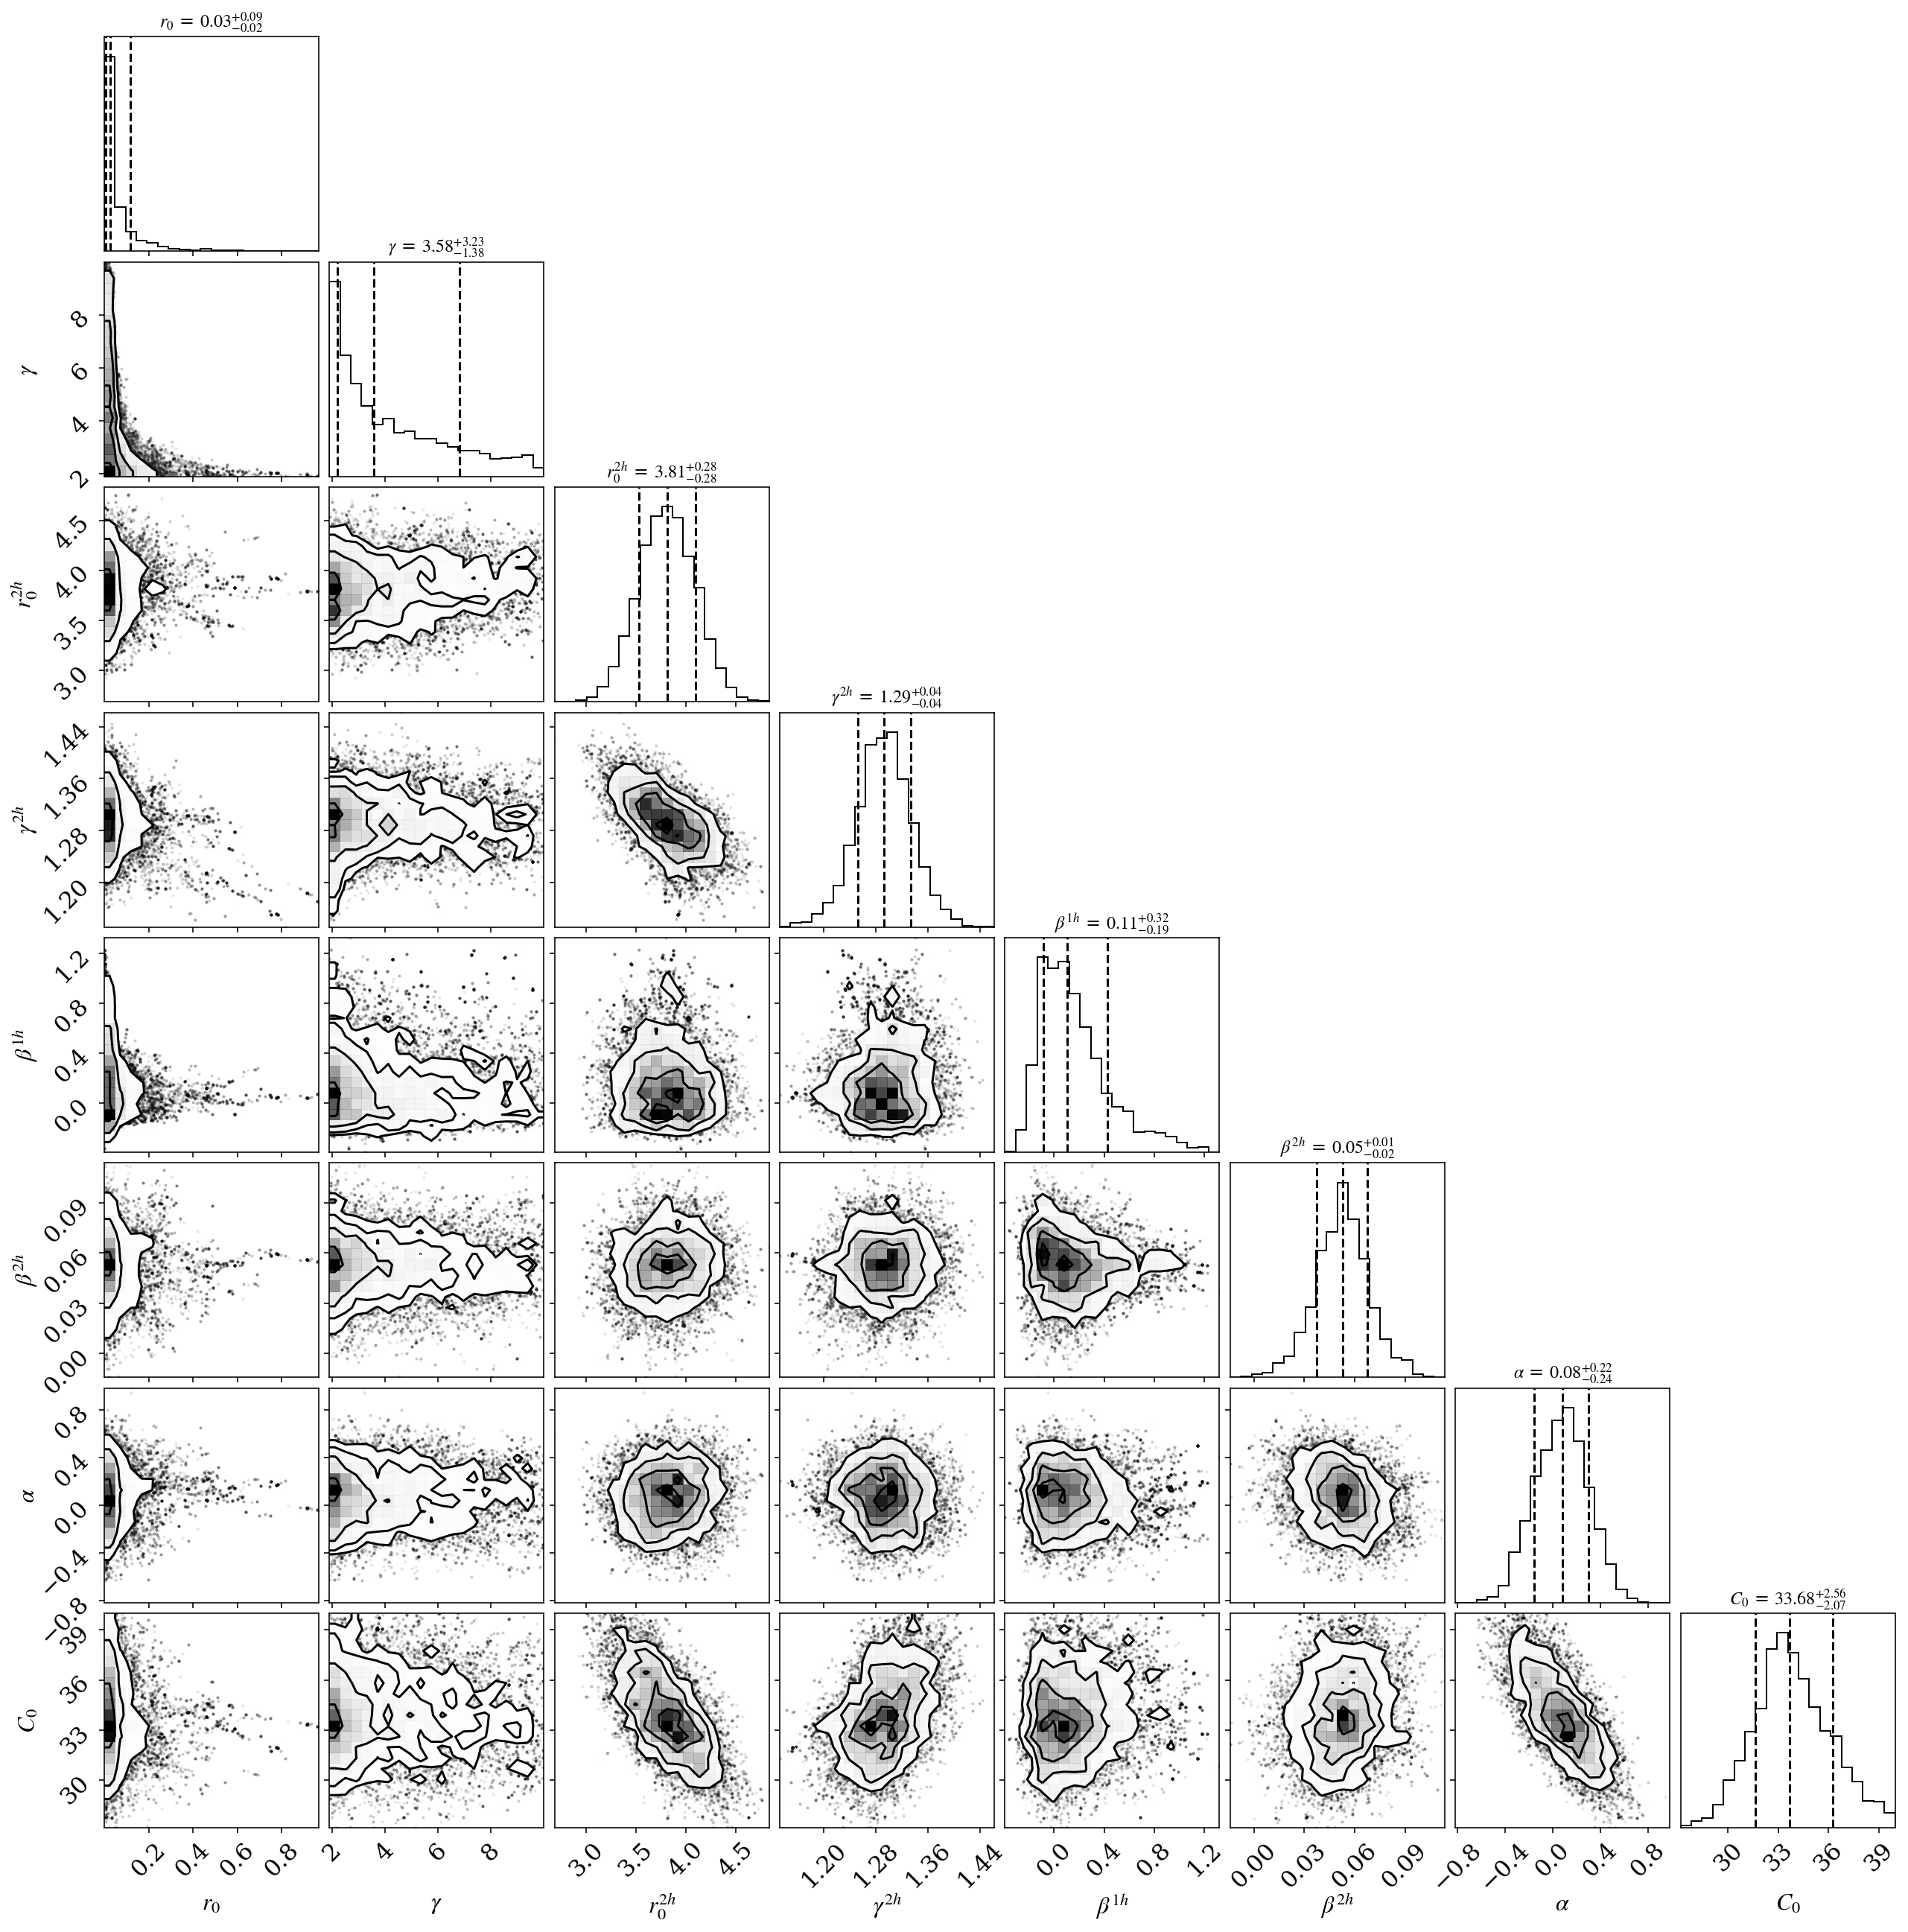

In [18]:
import corner
fig = corner.corner(
    flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}
);
fig.savefig('corner_velocity_1h2h.png')

In [19]:
np.median(flat_samples, axis=0)

array([2.77796515e-02, 3.58100992e+00, 3.81260617e+00, 1.29291274e+00,
       1.06114315e-01, 5.29189638e-02, 7.98478115e-02, 3.36801642e+01])